In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

from feature_extraction.beats_extractor import load_models as load_beats, preprocess_audio, extract_beats_features
from feature_extraction.clip_extractor import initialize_clip_model, extract_clip_features, save_clip_features
from scipy.io import savemat
import pathlib
import numpy as np

# load the audio model
BEATs_tokenizer, BEATs_model = load_beats()

# preprocess audio
waveform, sr = preprocess_audio("../rest_audio.wav")  # assumes rest_audio.wav in project root

# extract beats features averaged per second
features_per_sec, labels = extract_beats_features(waveform, BEATs_tokenizer, BEATs_model, sample_rate=sr)

# save audio features
savemat("features_per_sec.mat", {"features_per_sec": features_per_sec})

# load CLIP model
processor, vision_model = initialize_clip_model()

# extract frame numbers from saved frames
frames_dir = "../feature_extraction/frames"  # confirmed working path
import cv2
video_path = "../movie.mp4"
cap = cv2.VideoCapture(video_path)
frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)
total_seconds = int(np.ceil(frame_count / fps))

frame_indices = np.arange(total_seconds)


# extract CLIP features for all frames
clip_features = extract_clip_features(frames_dir, frame_indices, processor, vision_model)

# save vision features
save_clip_features(clip_features, "vision_clip_features.mat")


/opt/conda/envs/pytorch-dev/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
366it [00:30, 12.19it/s]                                                        
Extracting CLIP features: 100%|█████████████| 3655/3655 [04:13<00:00, 14.40it/s]

Final CLIP feature shape: (3655, 768)
Saved features to vision_clip_features.mat


In [2]:
# load features from mat files
import scipy.io as sio

Audio_path = "features_per_sec.mat"
Vision_path = "vision_clip_features.mat"

data_audio = sio.loadmat(Audio_path)['features_per_sec']
data_vision = sio.loadmat(Vision_path)['features']

data_audio.shape, data_vision.shape


((3655, 768), (3655, 768))

In [2]:
data = np.concatenate((data_audio, data_vision), axis=1)
print('Feature space dimensions:', data.shape)

Feature space dimensions: (3655, 1536)


In [2]:
# Load Brain data
LH_path = '../notmean_left_Meanfile.mat'
RH_path = '../notmean_right_Meanfile.mat'

data_LH = sio.loadmat(LH_path)['Left_data']
data_RH = sio.loadmat(RH_path)['Right_data']

data_RH.shape, data_LH.shape

((32492, 3655), (32492, 3655))

In [4]:
brain = np.concatenate((data_LH, data_RH), axis=0)
brain = brain.transpose()

print('Brain data dimensions:', brain.shape)

Brain data dimensions: (3655, 64984)


In [5]:
# Normalize data
def normalize_data(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    normalized_data = (data - mean) / (std + 1e-8) 
    print(f"std.min = {std.min()}, std.max = {std.max()}")
    if std.any() == 0:
        print("Warning: Standard deviation is zero for some features, normalization may not be effective.")
    return normalized_data

data = normalize_data(data)
brain = normalize_data(brain)

std.min = 0.012566308490931988, std.max = 1.6923041343688965
std.min = 0.0, std.max = 1.3306655238461678


In [13]:
def create_training_data(data, activity, delay):

    data = np.roll(data, delay, axis=0)
    
    return data, activity

In [15]:
# split data and brain to train and test
data_train = data[:int(data.shape[0] * 0.8)]
data_test = data[int(data.shape[0] * 0.8):]
brain_train = brain[:int(brain.shape[0] * 0.8)]
brain_test = brain[int(brain.shape[0] * 0.8):]

# print shapes
print('Train data shape:', data_train.shape)
print('Test data shape:', data_test.shape)
print('Train brain shape:', brain_train.shape)
print('Test brain shape:', brain_test.shape)

Train data shape: (2924, 1536)
Test data shape: (731, 1536)
Train brain shape: (2924, 64984)
Test brain shape: (731, 64984)


In [18]:
from sklearn.linear_model import LinearRegression
import joblib
from tqdm import tqdm
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def calculate_r_values(predicted, activity):
    r_values = []
    for i in range(activity.shape[1]):
        r, _ = pearsonr(predicted[:, i], activity[:, i])
        r_values.append(r)
    return np.array(r_values)

In [ ]:
r_values_list = []
plt.figure(figsize=(10, 5))
for delay in range(0, 10):
    x_train, y_train = create_training_data(data_train, brain_train, delay)
    x_test, y_test = create_training_data(data_test, brain_test, delay)

    model = LinearRegression()
    model.fit(x_train, y_train)

    predicted = model.predict(x_test)
    r_values = calculate_r_values(predicted, y_test)

    r_values_list.append(r_values)

    # plot histogram of r values
    plt.hist(r_values, bins=50, color='blue', alpha=0.7)
    plt.title(f'Histogram of R Values - Delay {delay}')
    plt.xlabel('R Value')
    plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', label='Zero Line')
plt.legend()
plt.show()

In [ ]:
for ind, r_values in enumerate(r_values_list):
    # replace nan values with 0
    r_values = np.nan_to_num(r_values, nan=0.0)
    # print(f"R values for delay {ind}:")
    # print(r_values)
    print(f"{ind} ==> Mean R value: {np.mean(r_values)}")
    # print(f"Max R value: {np.max(r_values)}")
    # print(f"Min R value: {np.min(r_values)}")

0 ==> Mean R value: 0.09130468514522554
1 ==> Mean R value: 0.09745208947544147
2 ==> Mean R value: 0.11961468988167887
3 ==> Mean R value: 0.1503482671942227
4 ==> Mean R value: 0.1597899710528575
5 ==> Mean R value: 0.15305630297241685
6 ==> Mean R value: 0.1368260905431802
7 ==> Mean R value: 0.11734160925632078
8 ==> Mean R value: 0.1049264806286522
9 ==> Mean R value: 0.10282426406221173


/var/folders/ty/6cj0ly9j2wb27pn1syqcsytc0000gn/T/ipykernel_52735/2443879306.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


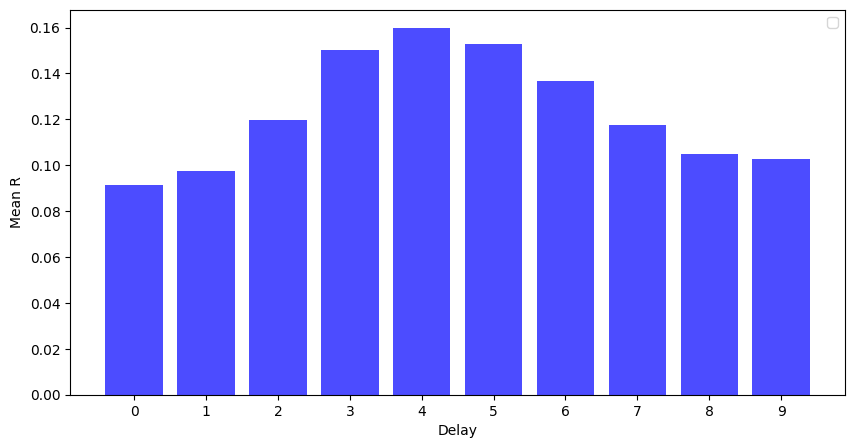

In [34]:
r_list = []
for ind, r_values in enumerate(r_values_list):
    # replace nan values with 0
    r_values = np.nan_to_num(r_values, nan=0.0)
    r_list.append((np.mean(r_values),np.std(r_values)))
# print(r_list)

# plot mean and std of r values
plt.figure(figsize=(10, 5))
plt.bar(range(len(r_list)), [x[0] for x in r_list], color='blue', alpha=0.7)
plt.xlabel('Delay')
plt.ylabel('Mean R')
plt.xticks(range(len(r_list)))
plt.legend()
plt.show()